### Can we classify each phase as relatively low or high anxiety for each subject? ###
#### APD, WESAD ####

In [1]:
# IMPORTING MODULES
import glob
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
cvx_path = os.path.abspath(os.path.join('..', '..', 'cvxEDA', 'src'))
module_path = os.path.abspath(os.path.join('..', '..', 'src'))
import pandas as pd
import random
import scipy.signal as ss
import shap
import sys
sys.path.append(module_path)

import tools.data_reader_apd as dr_a
import tools.data_reader_wesad as dr_w
import tools.display_tools as dt
import tools.preprocessing as preprocessing
import train

from scipy.fft import fft, fftfreq, fftshift
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.preprocessing import normalize
from xgboost import XGBClassifier

import cvxopt.solvers
cvxopt.solvers.options['show_progress'] = False

import warnings
warnings.filterwarnings(
    "ignore", 
    category=RuntimeWarning
)
warnings.simplefilter(action='ignore', category=FutureWarning)

c:\Users\zhoux\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
metrics = [
    train.Metrics.BPM, 
    train.Metrics.RMSSD, 
    train.Metrics.HF_RR, 
    train.Metrics.LF_RR, 
    # train.Metrics.IBI, 
    train.Metrics.SDNN, 
    train.Metrics.MEAN_SCL, 
    train.Metrics.SCR_RATE
]

model_phases_apd = [
    "Baseline_Rest", 
    "BugBox_Relax", "BugBox_Anticipate", "BugBox_Exposure", "BugBox_Break",
    "Speech_Relax", "Speech_Anticipate", "Speech_Exposure", "Speech_Break"
]

model_phases_wesad = dr_w.Phases.PHASE_ORDER

# anxiety_label_type = "Anxiety"
anxiety_label_type = None
wesad_label_type = "stai"

models = {
    # "SVM": SVC(C=10, gamma=1),  # C=10, gamma=1
    # "KNN": KNeighborsClassifier(n_neighbors=7),
    # "DT": DecisionTreeClassifier(),
    "LogReg": LogisticRegression(max_iter=1000),
    # "Bayes": GaussianNB(),
    "RF": RandomForestClassifier(),
    "XGB": XGBClassifier(use_label_encoder=False, objective="binary:logistic", eval_metric="logloss")
}

threshold = "fixed"
test_size = 1.0

temp_a, _ = train.Train_APD.get_apd_data_ranking([train.Metrics.BPM], phases=dr_a.Phases.PHASES_LIST)
idx = temp_a[temp_a["bpm"] > 200].index 
invalid_apd_subjects = set(temp_a["subject"].iloc[idx].tolist())
idx = temp_a[temp_a["bpm"] < 35].index 
invalid_apd_subjects.update(set(temp_a["subject"].iloc[idx].tolist()))

Ratio of positive to negative labels (0.2857142857142857) is under 0.333, oversampling positive class.
Ratio of positive to negative labels (0.2727272727272727) is under 0.333, oversampling positive class.
y_train:
0    315
1    104
Name: label, dtype: int64
y_test:
0    55
1    18
Name: label, dtype: int64
Model LogReg, Predictions: [0 1], [41 32]
Calculating shap values
Model RF, Predictions: [0 1], [10 63]
Calculating shap values
Model XGB, Predictions: [0 1], [14 59]
Calculating shap values
[[ 0.16196205 -0.01025953  0.81261925  1.39675682  0.31887508  0.98685416
  -0.43537671  1.79920972]]
[0.13272612 0.10543994 0.12949117 0.13252341 0.10437274 0.1431559
 0.12026168 0.13202905]


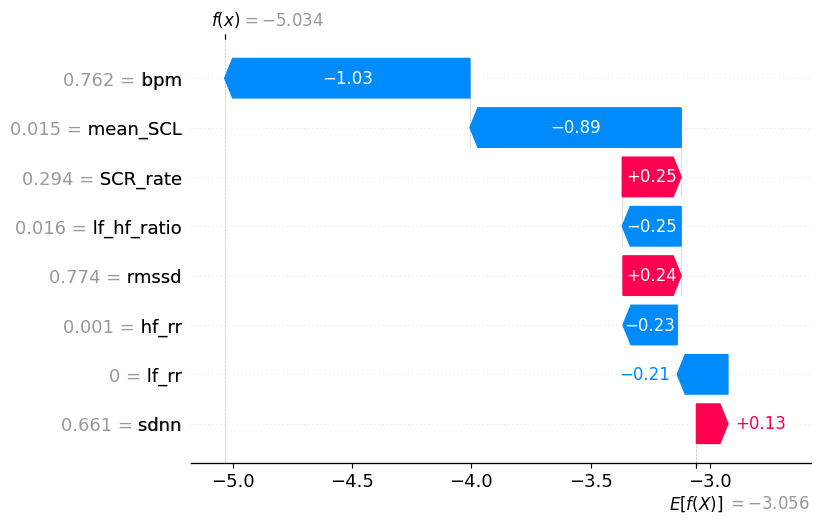

LogReg accuracy over 1 rounds: 0.6164383561643836
Model evaluation metrics for LogReg:
Precision: 0.34375
Recall: 0.6111111111111112
F1-score: 0.44000000000000006
AUC score: 0.6146464646464647
RF accuracy over 1 rounds: 0.3835616438356164
Model evaluation metrics for RF:
Precision: 0.2857142857142857
Recall: 1.0
F1-score: 0.4444444444444445
AUC score: 0.5909090909090908
XGB accuracy over 1 rounds: 0.3561643835616438
Model evaluation metrics for XGB:
Precision: 0.2542372881355932
Recall: 0.8333333333333334
F1-score: 0.38961038961038963
AUC score: 0.5166666666666667




In [13]:
# TRAIN ON APD AND TEST ON WESAD
importlib.reload(train)
importlib.reload(dr_a)
importlib.reload(dr_w)
importlib.reload(dt)


# for j, phases_wesad in enumerate(model_phases_wesad):
#     phases_wesad = [phases_wesad]
#     print(f"WESAD PHASES {phases_wesad} " + "-"*50)
x_a, y_a = train.Train_APD.get_apd_data_ranking(metrics, model_phases_apd, verbose=False, anxiety_label_type=anxiety_label_type, threshold=threshold, normalize=True)
# x_b, y_b = train.Train_WESAD.get_wesad_data(metrics, phases_wesad, verbose=False, label_type=wesad_label_type, threshold=threshold, normalize=True)
x_b, y_b = train.Train_WESAD.get_wesad_data(metrics, model_phases_wesad, verbose=False, label_type=wesad_label_type, threshold=threshold, normalize=True)
# drop subjects with noisy data
x_a = x_a[~x_a["subject"].isin(invalid_apd_subjects)].reset_index(drop=True)
y_a = y_a[~y_a["subject"].isin(invalid_apd_subjects)].reset_index(drop=True)

if anxiety_label_type is not None:
    x_a = x_a.drop(["anxietyGroup"], axis=1)  # drop anxietyGroup column because WESAD doesn't have this feature

x_a = x_a.drop(["phaseId"], axis=1)
x_b = x_b.drop(["phaseId"], axis=1)

# make sure subjects from different datasets aren't labeled with the same index
x_b["subject"] = x_b["subject"] + 500
y_b["subject"] = y_b["subject"] + 500

acc_results = {
    # "SVM": [],
    "LogReg": [],
    "RF": [],
    "XGB": []
}
reports = {
    # "SVM": [],
    "LogReg": [],
    "RF": [],
    "XGB": []
}
num_iters = 1
get_shap = True
for _ in range(num_iters):
    out = train.Train_Multi_Dataset.train_across_datasets(models, x_a, y_a, x_b, y_b, by_subject=True, save_metrics=True, test_size=test_size, is_resample=True, get_shap_values=get_shap, drop_subject=True)
    for model_name in acc_results:
        acc_results[model_name].append(out[model_name][0])
        reports[model_name].append(out[model_name][1])
        if get_shap:
            try:
                shap.plots.waterfall(out[model_name][2][0])
            except Exception as e:
                print(out[model_name][2])

for model_name in acc_results.keys():
    acc = np.mean(acc_results[model_name])
    print(f"{model_name} accuracy over {num_iters} rounds: {acc}")
    if acc > 0.0:
        print(f"Model evaluation metrics for {model_name}:")
        p = np.mean([report["precision"] for report in reports[model_name]])
        r = np.mean([report["recall"] for report in reports[model_name]])
        f1 = np.mean([report["f1"] for report in reports[model_name]])
        auc = np.mean([report["auc"] for report in reports[model_name]])
        report = reports[model_name]
        print(f"Precision: {p}\nRecall: {r}\nF1-score: {f1}\nAUC score: {auc}")
print("\n")

Ratio of positive to negative labels (0.2727272727272727) is under 0.333, oversampling positive class.
Ratio of positive to negative labels (0.2857142857142857) is under 0.333, oversampling positive class.
y_train:
0    55
1    18
Name: label, dtype: int64
y_test:
0    315
1    104
Name: label, dtype: int64
Model LogReg, Predictions: [0 1], [418   1]
Calculating shap values
Model RF, Predictions: [0 1], [280 139]
Calculating shap values
Model XGB, Predictions: [0 1], [ 17 402]
Calculating shap values
[[ 2.01933933  0.61696124  0.09648457  0.74400631 -0.13303586  1.23669686
   0.57304722 -0.58635946]]
[0.22663437 0.10525996 0.13752705 0.0916548  0.07243184 0.17019994
 0.12029883 0.07599321]


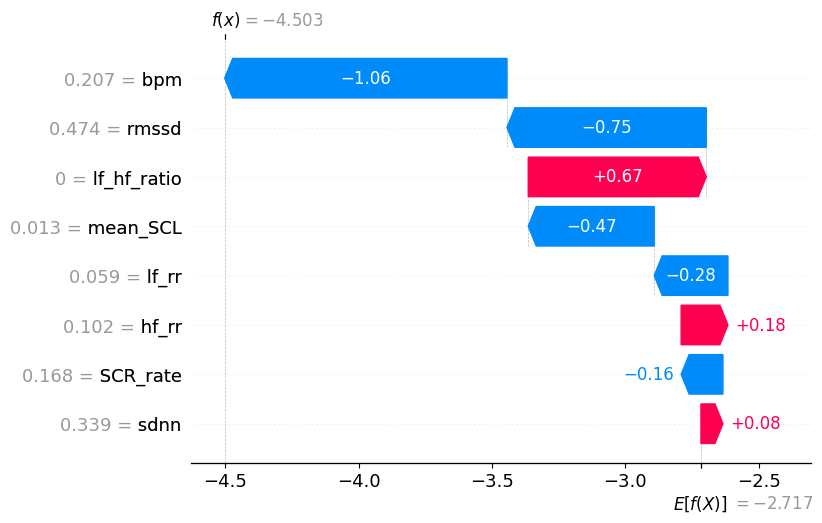

LogReg accuracy over 1 rounds: 0.7541766109785203
Report:
	Precision: 1.0
	Recall: 0.009615384615384616
	F1-score: 0.01904761904761905
	AUC score: 0.5048076923076923
RF accuracy over 1 rounds: 0.5536992840095465
Report:
	Precision: 0.2014388489208633
	Recall: 0.2692307692307692
	F1-score: 0.23045267489711932
	AUC score: 0.45842490842490835
XGB accuracy over 1 rounds: 0.2458233890214797
Report:
	Precision: 0.236318407960199
	Recall: 0.9134615384615384
	F1-score: 0.37549407114624506
	AUC score: 0.4694291819291819




In [12]:
# TRAIN ON WESAD AND TEST ON APD
importlib.reload(train)
importlib.reload(dr_a)
importlib.reload(dr_w)
importlib.reload(dt)


# for j, phases_apd in enumerate(model_phases_apd):
#     # print(f"WESAD PHASES {i} " + "-"*50)
#     print(f"APD PHASES {phases_apd} " + "-"*50)
    # phases_apd = [phases_apd]
x_a, y_a = train.Train_WESAD.get_wesad_data(metrics, model_phases_wesad, verbose=False, label_type=wesad_label_type, threshold=threshold, normalize=True)
# x_b, y_b = train.Train_APD.get_apd_data_ranking(metrics, phases_apd, verbose=False, anxiety_label_type=anxiety_label_type, threshold=threshold, normalize=True)
x_b, y_b = train.Train_APD.get_apd_data_ranking(metrics, model_phases_apd, verbose=False, anxiety_label_type=anxiety_label_type, threshold=threshold, normalize=True)
# drop subjects with noisy data
x_b = x_b[~x_b["subject"].isin(invalid_apd_subjects)].reset_index(drop=True)
y_b = y_b[~y_b["subject"].isin(invalid_apd_subjects)].reset_index(drop=True)
if anxiety_label_type is not None:
    x_b = x_b.drop(["anxietyGroup"], axis=1)  # drop anxietyGroup column because WESAD doesn't have this feature

x_a = x_a.drop(["phaseId"], axis=1)
x_b = x_b.drop(["phaseId"], axis=1)

# make sure subjects from different datasets aren't labeled with the same index
x_b["subject"] = x_b["subject"] + 500
y_b["subject"] = y_b["subject"] + 500

acc_results = {
    # "SVM": [],
    "LogReg": [],
    "RF": [],
    "XGB": []
}
reports = {
    # "SVM": [],
    "LogReg": [],
    "RF": [],
    "XGB": []
}
num_iters = 1
get_shap = True
for _ in range(num_iters):
    out = train.Train_Multi_Dataset.train_across_datasets(models, x_a, y_a, x_b, y_b, by_subject=True, is_resample=True, test_size=test_size, save_metrics=True, get_shap_values=get_shap, drop_subject=True)
    for model_name in acc_results:
        acc_results[model_name].append(out[model_name][0])
        reports[model_name].append(out[model_name][1])
        if get_shap:
            try:
                shap.plots.waterfall(out[model_name][2][0])
            except Exception as e:
                print(out[model_name][2])

for model_name in acc_results.keys():
    acc = np.mean(acc_results[model_name])
    print(f"{model_name} accuracy over {num_iters} rounds: {acc}")
    if acc > 0.0:
        p = np.mean([report["precision"] for report in reports[model_name]])
        r = np.mean([report["recall"] for report in reports[model_name]])
        f1 = np.mean([report["f1"] for report in reports[model_name]])
        auc = np.mean([report["auc"] for report in reports[model_name]])
        report = reports[model_name]
        print(f"Report:\n\tPrecision: {p}\n\tRecall: {r}\n\tF1-score: {f1}\n\tAUC score: {auc}")
print("\n")